In [4]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file. 

This notebook demonstrates how to retrieve SMAP data via OpenDAP from NSIDC. Specifically, we will:
* Retrieve data for a specified date and region
* Retrieve data for specified points over a date range


Add a thumbnail image of the results

# How to retrieve SMAP data via OpenDAP using PODPAC
* Make sure you have PODPAC properly installed WITH the **datatype** optional dependencies: `pip install podpac[datatype]`

# Setup

In [6]:
import podpac  # This line import the podpac library into Python

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username:mpuecker
Password:········


## Create the PODPAC SMAP Node

In [8]:
# Create the SMAP node
product = 'SPL4SMAU'   # Level 4 soil moisture analysis update
sm = podpac.datalib.SMAP(product=product,
                         interpolation='nearest',
                         username=username, password=password)
sm

##  Retrieve data for a specified date and region
Note, this example:
* Retrieves data from NSIDC via OpenDAP
* Only downloads data for the requested region and data product
* Caches it locally
* Automatically does nearest-neighbor interpolation to the user's specified grid

In [34]:
# Specify region of interest on a uniform grid
lat = podpac.crange(60,     10, -2.0)  # (start, stop, step)
lon = podpac.crange(-130, -60,  2.0)  # (start, stop, step)
# Specify date and time
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
coords_world = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

# Evaluate the node to retrieve and interpolate the data
smap_data = sm.eval(coords_world)

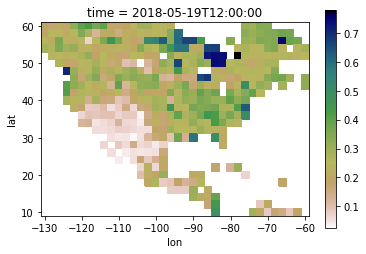

In [35]:
# Plot the result
figure()
smap_data.plot(cmap='gist_earth_r')
ax = axis('scaled')

## Retrieve data for specified points over a date range
Note, this example:
* Retrieves subsetted data from NSIDC via OpenDAP
* Caches it locally
* Accesses multiple (24) SMAP files in parallel


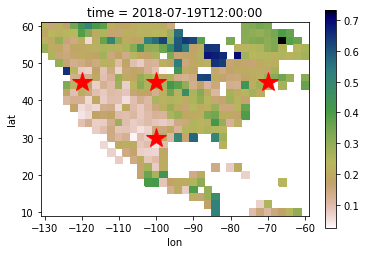

In [30]:
# Look at a list of points
lat_lon_pts = np.array([
    (  45.0, 45.0,  45.0, 30.0),  # Lat
    (-100.0, -70, -120.0, -100.0), # Lon
])

# Let's plot the points
figure()
smap_data.plot(cmap='gist_earth_r')
axis('scaled')
ax = plot(lat_lon_pts[1], lat_lon_pts[0], 'r*', ms=20)

In [32]:
# Specify the time range
time = podpac.crange('2018-05-15T00', '2018-05-19T00', '3,h')

# Create the PODPAC coordinates
coords_pts = podpac.Coordinates([lat_lon_pts, time], dims=['lat_lon', 'time'])

# To improve the speed of data retrieval, make 6 requests in parallel
sm.threaded = True; sm.n_threads = 6

# Evaluate the node to retrieve and interpolate the data
smap_data_time = sm.eval(coords_pts)

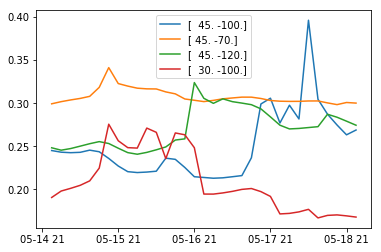

In [33]:
# Plot the results
figure()
plot(smap_data_time.time, smap_data_time.data.T)
legend([str(llp) for llp in lat_lon_pts.T])
locs, labels = xticks()
ax = xticks(locs[::2])